# Overhead Analysis

In [1]:
from __future__ import annotations

import json
import os
import pathlib
import tomllib

import seaborn
import polars
from matplotlib import pyplot as plt

_ = polars.Config.set_tbl_rows(100)

In [2]:
def load_tasks(filepath: pathlib.Path) -> list[dict]:
    tasks = []
    with open(filepath) as f:
        for line in f.readlines():
            task_info = json.loads(line)
            execution_info = task_info.pop('execution')
            if execution_info is None:
                execution_info = {}
            exception_info = task_info.pop('exception')
            if exception_info is None:
                exception_info = {}
            task_info = {**task_info, **execution_info, **exception_info}
            tasks.append(task_info)

    return tasks

def load_data(directory: pathlib.Path) -> polars.DataFrame:
    runs = []

    for tasks_path in directory.glob('**/tasks.jsonl'):
        method, timestamp = str(tasks_path.relative_to(directory).parent).split('/')

        method = {'baseline': 'Baseline', 'proxystore': 'ProxyStore'}[method]
        
        with open(tasks_path.parent / 'config.toml', 'rb') as f:
            config = tomllib.load(f)
            size = config['app']['task_data_bytes']

        for task in load_tasks(tasks_path):
            start_time = task['submit_time']
            end_time = task['received_time']       
            roundtrip = (end_time - start_time) * 1000
    
            run_info = {
                'method': method,
                'timestamp': timestamp,
                'roundtrip': roundtrip,
                'size': size,
            }
            runs.append(run_info)

    return polars.DataFrame(runs)

In [3]:
data = load_data(pathlib.Path('runs/roundtrip'))

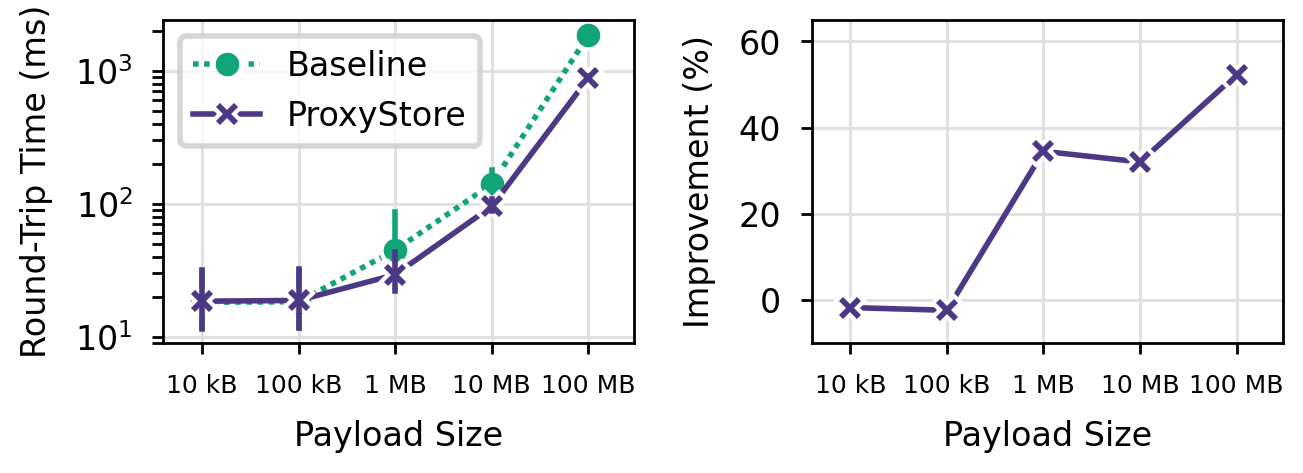

In [4]:
fig, axs = plt.subplots(1, 2)

xticks = list(sorted(set(data['size'].to_list())))
xtick_labels = ['10 kB', '100 kB', '1 MB', '10 MB', '100 MB',]

dashes = {'Baseline': (1, 1), 'ProxyStore': ()}
markers = {'Baseline': 'o', 'ProxyStore': 'X'}
palette = {'Baseline': '#11A579', 'ProxyStore': '#4D3886'}

handle = seaborn.lineplot(
    data,
    x="size",
    y="roundtrip",
    hue="method",
    hue_order=["Baseline", "ProxyStore"],
    errorbar='ci',
    err_style='bars',
    style="method",
    dashes=dashes,
    markers=markers,
    linewidth=1,
    markersize=5,
    palette=palette,
    ax=axs[0],
)
handle.get_legend().set_title(None)
handle.set(
    xscale='log',
    yscale='log',
    xlabel='Payload Size',
    ylabel='Round-Trip Time (ms)',
    xlim=(4000, 300_000_000),
)
handle.set_xticks(xticks, minor=False)
handle.set_xticklabels(xtick_labels, size=4.5)
axs[0].tick_params(axis='x', which='minor', bottom=False)

summary = data.group_by('method', 'size').mean()
summary = summary.pivot('method', values='roundtrip')
summary = summary.with_columns(
    (100 * (polars.col('Baseline') - polars.col('ProxyStore')) / polars.col('Baseline')).alias('improvement'),
    polars.lit('ProxyStore').alias('method'),
)

handle = seaborn.lineplot(
    summary,
    x="size",
    y="improvement",
    hue='method',
    style="method",
    markers=markers,
    linewidth=1,
    markersize=5,
    palette=palette,
    ax=axs[1],
)
handle.get_legend().remove()
handle.set(
    xscale='log',
    xlabel='Payload Size',
    ylabel='Improvement (%)',
    ylim=(-10, 65),
    xlim=(4000, 300_000_000),
)
handle.set_xticks(xticks, minor=False)
handle.set_xticklabels(xtick_labels, size=4.5)
axs[1].tick_params(axis='x', which='minor', bottom=False)

fig.tight_layout(w_pad=1)
fig.set_size_inches(3.35, 1)
fig.savefig('figures/overheads.pdf')